In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.stats import norm

from tqdm import tqdm

In [2]:
cashflow = [1920, 3090, 4000, 4650, 5040, 5170, 5040, 4650, 4000, 3090, 1920, 490, -470, -920, -1350, -1760, -2150, -2520, -2870, -3200, -3510, -3800, -4070, -4320, -4550, -4760, -4950, -5120, -5270, -5400, -5510, -5600, -5670, -5720, -5750, -5760, -5750, -5720, -5670, -5600, -5510, -5400, -5270, -5120, -4950, -4760, -4550, -4320, -4070, -3800, -3510, -3200, -2870, -2520, -2150, -1760, -1350, -920, -470, 0]

files = []
for i in range(2002,2023):
    files.append(str(i) + '.csv')
    
df = pd.DataFrame()

for i in range(0,21):
    temp = pd.read_csv(files[i])
    temp.set_index('Date', inplace=True)
    temp.index = pd.to_datetime(temp.index)
    df_month_end = temp.resample('M').last()
    df = pd.concat([df_month_end, df])
    

In [3]:
start_date = '2002-12-31'
df = df.loc[df.index >= start_date]
df

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,,
2022-01-31,0.03,0.13,0.22,NaN,0.49,0.78,1.18,1.39,1.62,1.75,1.79,2.17,2.11
2022-02-28,0.06,0.20,0.35,NaN,0.69,1.01,1.44,1.62,1.71,1.81,1.83,2.25,2.17
2022-03-31,0.17,0.35,0.52,NaN,1.06,1.63,2.28,2.45,2.42,2.40,2.32,2.59,2.44
2022-04-30,0.37,0.73,0.85,NaN,1.41,2.10,2.70,2.87,2.92,2.94,2.89,3.14,2.96
2022-05-31,0.73,0.89,1.16,NaN,1.64,2.08,2.53,2.71,2.81,2.87,2.85,3.28,3.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-09-30,0.87,NaN,0.95,NaN,1.01,1.15,1.50,1.95,2.85,3.41,3.96,4.91,NaN
2003-10-31,0.96,NaN,0.96,NaN,1.04,1.31,1.85,2.36,3.27,3.80,4.33,5.20,NaN
2003-11-30,0.96,NaN,0.93,NaN,1.04,1.39,2.06,2.56,3.38,3.89,4.34,5.20,NaN


In [4]:
drop = ['1 Mo', '2 Mo', '3 Mo', '4 Mo']
df = df.drop(drop, axis = 1)
df = df.dropna()
df = df.sort_index()
df

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,
2006-02-28,4.74,4.73,4.69,4.67,4.61,4.57,4.55,4.70,4.51
2006-03-31,4.81,4.82,4.82,4.83,4.82,4.83,4.86,5.07,4.90
2006-04-30,4.91,4.90,4.87,4.87,4.92,4.98,5.07,5.31,5.17
2006-05-31,5.08,5.07,5.04,5.03,5.04,5.06,5.12,5.35,5.21
2006-06-30,5.24,5.21,5.16,5.13,5.10,5.11,5.15,5.31,5.19
...,...,...,...,...,...,...,...,...,...
2022-08-31,3.32,3.50,3.45,3.46,3.30,3.25,3.15,3.53,3.27
2022-09-30,3.92,4.05,4.22,4.25,4.06,3.97,3.83,4.08,3.79
2022-10-31,4.57,4.66,4.51,4.45,4.27,4.18,4.10,4.44,4.22


In [5]:
curve = df.loc['2022-12-31']/100
curve

6 Mo     0.0476
1 Yr     0.0473
2 Yr     0.0441
3 Yr     0.0422
5 Yr     0.0399
7 Yr     0.0396
10 Yr    0.0388
20 Yr    0.0414
30 Yr    0.0397
Name: 2022-12-31 00:00:00, dtype: float64

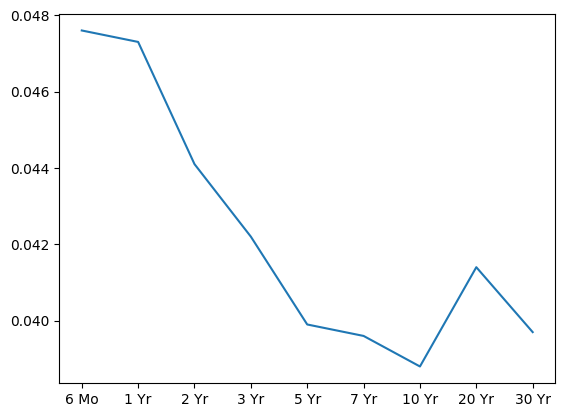

In [6]:
plt.plot(curve)

In [7]:
T = np.array([0.5, 1, 2, 3, 5, 7, 10, 20, 30])
half_years = np.linspace(0.5, 60 + 0.5, 120 + 1)

def bootstrap(yields):
    
    at_par = np.interp(half_years, T, yields)

    at_spot, discount = np.zeros(121), np.zeros(121)

    at_spot[0] = at_par[0]
    discount[0] = 1 + at_par[0]/2

    for i in range(1, 121):
        temp = 0
        
        for j in range(i):
            temp += 1/discount[j]
        last_payment = (1 - (at_par[i] / 2 * temp)) * 100
        
        at_spot[i] = (100 * (1 + at_par[i] / 2) / last_payment) ** (1/half_years[i]) - 1
        discount[i] = (1 + at_spot[i]) **   half_years[i]
        
    return at_spot[1::2]

Text(0.5, 1.0, 'Starting Yield Curve: Dec 31, 2022')

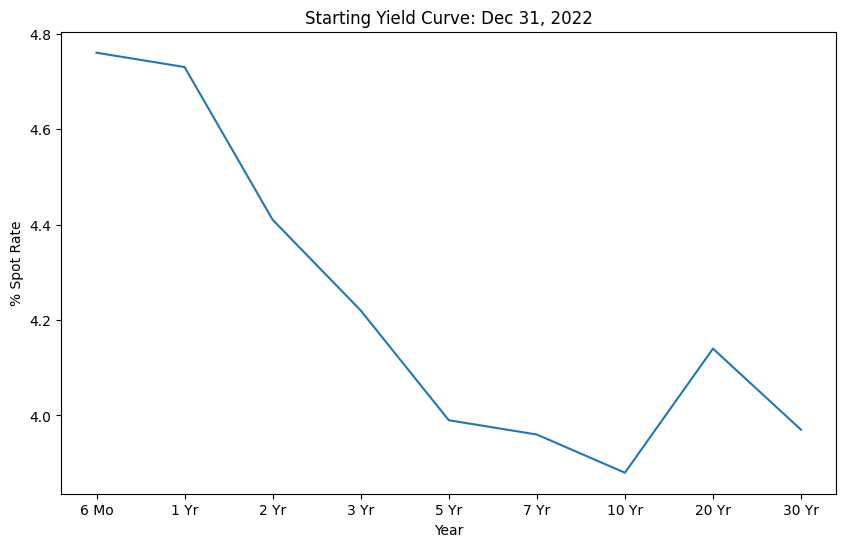

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(curve * 100)
plt.xlabel('Year')
plt.ylabel('% Spot Rate')
plt.title('Starting Yield Curve: Dec 31, 2022')

In [35]:
def calc_pv(cashflow, spot_rates):
    pv = []
    for i in range(len(cashflow)):
        pv.append(cashflow[i] / ((1 + spot_rates[i]) ** (i + 1)))
    
    return sum(pv)

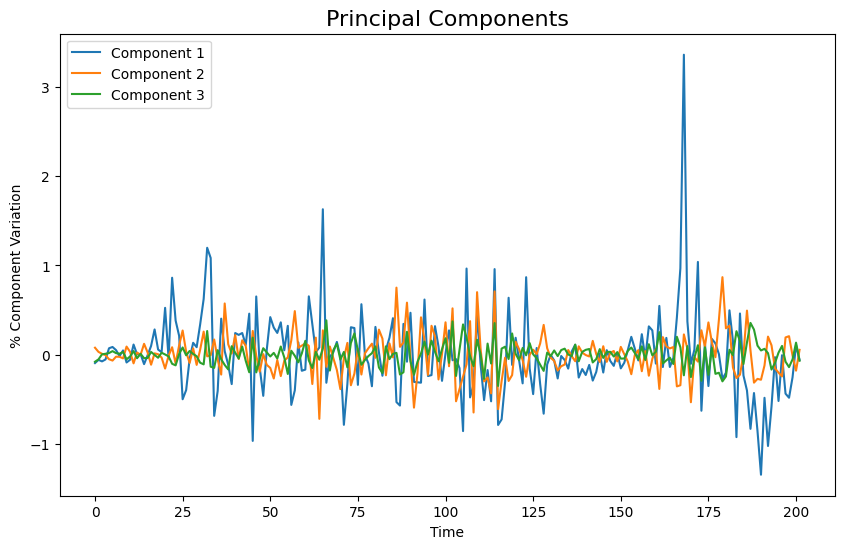

In [10]:
percent_log_change = np.log(df).diff().dropna()/100
pca = PCA(n_components=3)

pca.fit(percent_log_change)
mu = pca.mean_
C = pca.components_.T
sigma = np.sqrt(pca.explained_variance_)

components = pca.transform(percent_log_change)

plt.figure(figsize=(10, 6))
plt.plot(components[:, 0] * 100, label='Component 1')
plt.plot(components[:, 1] * 100, label='Component 2')
plt.plot(components[:, 2] * 100, label='Component 3')
plt.legend()
plt.title('Principal Components', fontsize = 16)
plt.xlabel('Time')
plt.ylabel('% Component Variation')
plt.show()

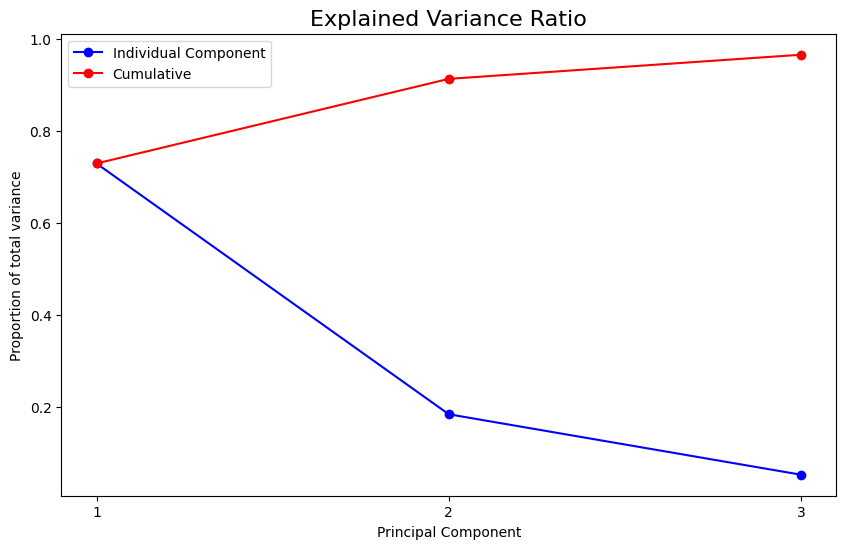

[0.7288053  0.1838472  0.05245683]
[0.7288053  0.91265251 0.96510933]


In [42]:
exp_var_ratio = pca.explained_variance_ratio_
cum_exp_var_ratio = np.cumsum(exp_var_ratio)

plt.figure(figsize=(10, 6))
plt.plot(exp_var_ratio, 'bo-', label='Individual Component')
plt.plot(cum_exp_var_ratio, 'ro-', label='Cumulative')
plt.legend()
plt.title('Explained Variance Ratio', fontsize = 16)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of total variance')
plt.xticks(np.arange(3), [1, 2, 3])
plt.show()

print(exp_var_ratio)
print(cum_exp_var_ratio)

In [12]:
C = C * -1


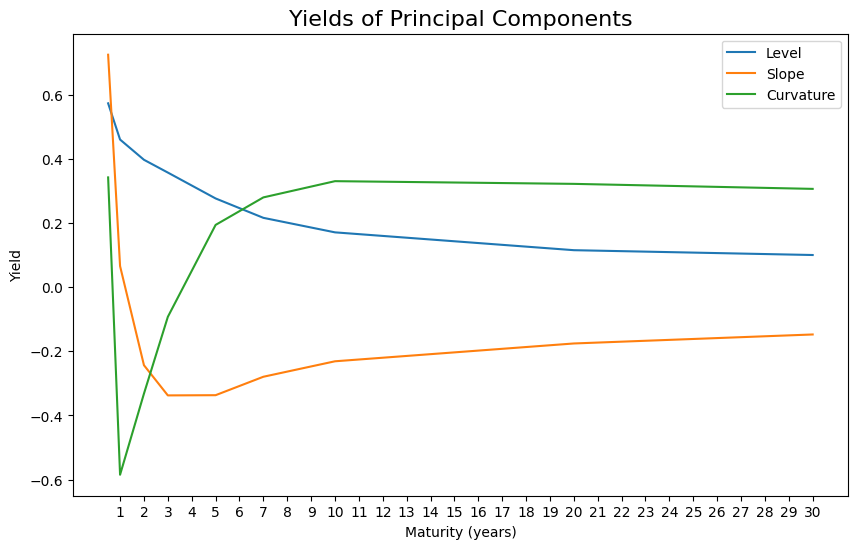

In [13]:
PC1 = mu +  C[:, 0]
PC2 = mu +  C[:, 1]
PC3 = mu +  C[:, 2]

plt.figure(figsize=(10, 6))
plt.plot(T, PC1, label='Level')
plt.plot(T, PC2, label='Slope')
plt.plot(T, PC3, label='Curvature')
plt.legend()
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Yields of Principal Components', fontsize = 16)
plt.xticks(np.arange(1, 31, 1))
plt.show()


In [30]:
def mc_simulation(Start_Curve, mu, sigma, nsims = 100000):
    
    yields = []
    spot_rates = []
    pvs = []
    static_drift = 0
    
    for i in tqdm(range(nsims)):
        
        noise = np.random.normal(0, np.sqrt(sigma), size=len(sigma))
        curve = Start_Curve * np.exp(mu + np.dot(C, noise)) + static_drift
        
        yields.append(curve)
        
        spots = bootstrap(curve)
        
        spot_rates.append(spots)
        pvs.append(calc_pv(cashflow, spots))
        
    return np.array(yields), np.array(spot_rates), np.array(pvs)    

In [43]:
yields, spot_rates, pv = mc_simulation(curve, mu * 12, sigma, nsims = 10_000)

100%|██████████| 10000/10000 [00:29<00:00, 337.60it/s]


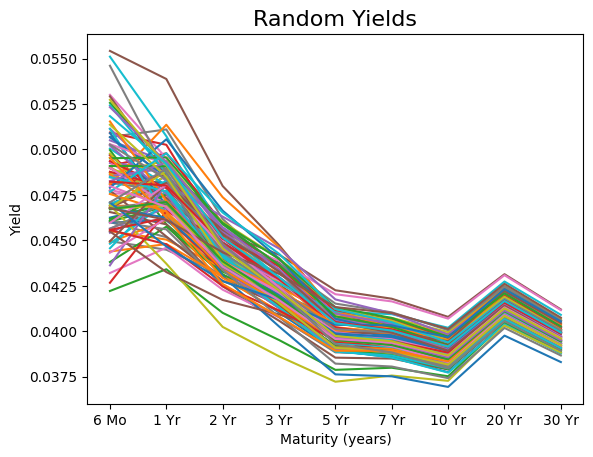

In [44]:
x_labels = list(df.columns)

for i in range(100):
    plt.plot(x_labels, yields[i])

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Random Yields', fontsize = 16)
plt.show()

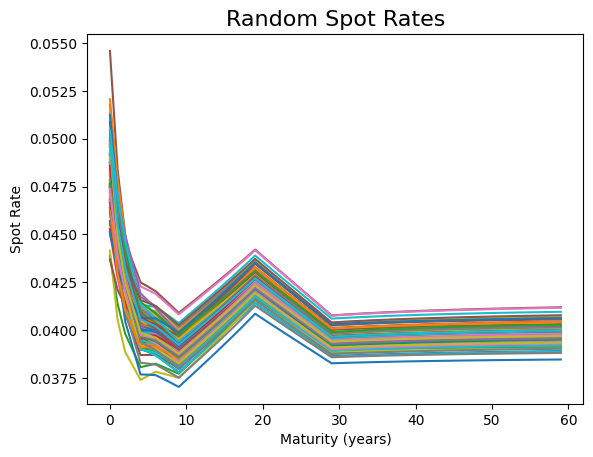

In [45]:
x_labels = list(df.columns)
for i in range(100):
    plt.plot(spot_rates[i])
    
plt.xlabel('Maturity (years)')
plt.ylabel('Spot Rate')
plt.title('Random Spot Rates', fontsize = 16)
plt.show()

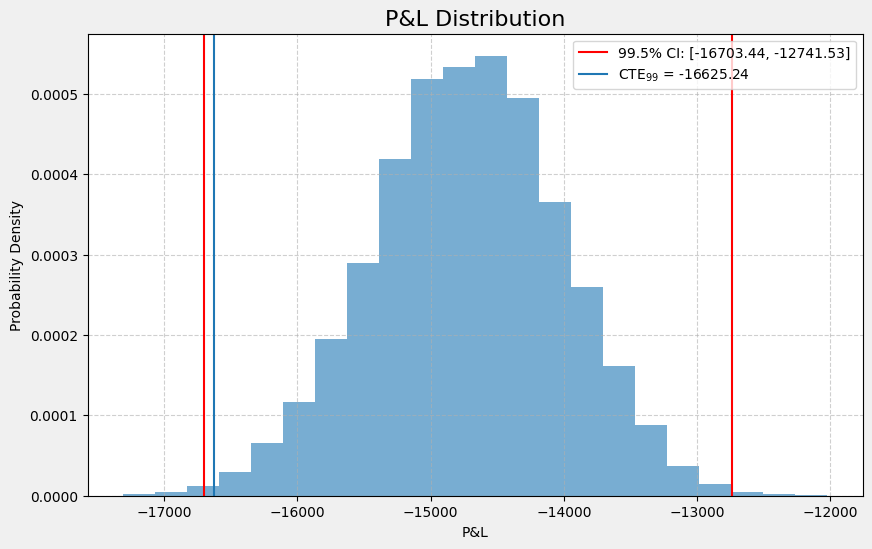

In [46]:
mean = np.mean(pv)
std = np.std(pv)

conf_interval = norm.interval(0.995, loc=mean, scale=std)
data_sorted = np.sort(pv)

VaR_99 = np.percentile(np.sort(pv), 1)
CTE_99 = np.mean(data_sorted[data_sorted <= VaR_99])

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(pv, bins=22, density=True, alpha=0.6)

conf_interval_str = f"[{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]"
ax.axvline(x=conf_interval[0], color='r')
ax.axvline(x=conf_interval[1], color='r', label=f'99.5% CI: {conf_interval_str}')
ax.axvline(x=CTE_99, label=f'CTE$_{{99}}$ = {CTE_99:.2f}')

ax.set_xlabel('P&L')
ax.set_ylabel('Probability Density')

ax.legend(loc='upper right', fancybox=True, framealpha=0.8)
ax.set_title('P&L Distribution', fontsize = 16)

ax.grid(True, linestyle='--', alpha=0.6)
fig.patch.set_facecolor('#F0F0F0')

plt.show()